In [1]:
from PIL import Image
from io import BytesIO
from threading import Thread

import torch
from matplotlib import pyplot as plt
from transformers import TextIteratorStreamer

from share4v.model.builder import load_pretrained_model
from share4v.mm_utils import (
    process_images,
    tokenizer_image_token,
)
from share4v.constants import (
    DEFAULT_IMAGE_TOKEN,
    DEFAULT_IM_START_TOKEN,
    DEFAULT_IM_END_TOKEN,
    IMAGE_TOKEN_INDEX,
)

/home/jupyter/.cache/pypoetry/virtualenvs/share4v-KfdsAbnj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jupyter/.cache/pypoetry/virtualenvs/share4v-KfdsAbnj-py3.10/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/home/jupyter/.cache/pypoetry/virtualenvs/share4v-KfdsAbnj-py3.10/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


In [2]:
# model configuration parameters
model_path = "Lin-Chen/ShareGPT4V-7B"
model_name = "share4v-7b"

# load the pretrained model, tokenizer, image processor, and context length
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path, None, model_name, False, False
)

share4v-7b
{'device_map': 'auto', 'torch_dtype': torch.float32}






/home/jupyter/.cache/pypoetry/virtualenvs/share4v-KfdsAbnj-py3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [00:25<00:00, 12.53s/it]


Load vision tower from Lin-Chen/ShareGPT4V-7B_Pretrained_vit-large336-l12


## Model architecture

In [3]:
model

Share4VLlamaForCausalLM(
  (model): Share4VLlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (nor

## Test model on an input

### Transform input text into tokens

In [343]:
prompt = "Tell me a joke about programming."
# prompt = "Tell me something interesting about this image: <image>"
stop_str = "<image>"

# tokenize the input prompt
input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt')

# add a batch dimension and move the tensor to the model's device
input_ids = input_ids.unsqueeze(0).to(model.device)

In [344]:
vocabulary = tokenizer.get_vocab()

In [345]:
input_ids

tensor([[    1, 24948,   592,   263,  2958,   446,  1048,  8720, 29889]])

In [346]:
for token_id in input_ids[0]:
    if token_id < 0:
        print(f"Token {token_id:5}: RESERVED_TOKEN")
        continue
    print(f"Token {token_id:5}: '{tokenizer.decode(token_id)}'")

Token     1: '<s>'
Token 24948: 'Tell'
Token   592: 'me'
Token   263: 'a'
Token  2958: 'jo'
Token   446: 'ke'
Token  1048: 'about'
Token  8720: 'programming'
Token 29889: '.'


### Load image

In [347]:
# load an example image
images = [
    Image.open("examples/breaking_bad.png"),
]

# ensure the number of images matches the number of image tokens in the prompt.
# if len(images) != prompt.count(DEFAULT_IMAGE_TOKEN):
#     raise ValueError("Number of images does not match number of <image> tokens in prompt")

images = process_images(images, image_processor, model.config)
if isinstance(images, list):
    images = [img.to(model.device, dtype=torch.float32) for img in images]
else:
    images = images.to(model.device, dtype=torch.float32)

In [202]:
# # replace the DEFAULT_IMAGE_TOKEN with the appropriate token format.
# replace_token = DEFAULT_IMAGE_TOKEN
# if getattr(model.config, 'mm_use_im_start_end', False):
#     replace_token = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN
# prompt = prompt.replace(DEFAULT_IMAGE_TOKEN, replace_token)

### Specify model parameters

In [350]:
temperature = 0.1
top_p = 0.95
max_new_tokens = 16

In [351]:
streamer = TextIteratorStreamer(
    tokenizer,
    skip_prompt=True,
    skip_special_tokens=True,
    timeout=150,
)

In [352]:
with torch.inference_mode():
    thread = Thread(target=model.generate, kwargs=dict(
        inputs=input_ids,
        do_sample=True,
        temperature=temperature,
        top_p=top_p,
        max_new_tokens=max_new_tokens,
        streamer=streamer,
        # stopping_criteria=[stopping_criteria],
        use_cache=True,
        # images=images,
    ))
    thread.start()

    print("Generated text:")
    generated_text = ""  # ori_prompt
    for new_text in streamer:
        generated_text += new_text
        if generated_text.endswith(stop_str):
            generated_text = generated_text[:-len(stop_str)]
        print(new_text, end="")
    print()

Generated text:


Why did the programmer go broke?

Because he spent all


In [353]:
thread.join()
del thread

## Trace inputs in model layers

In [355]:
embedded_tokens = model.model.embed_tokens(input_ids)
embedded_tokens.shape

torch.Size([1, 9, 4096])

In [356]:
import torch.nn.functional as F

def embedding_to_token_id(embedding, embed_tokens):
    # Get the embedding weight matrix (shape: vocab_size x embedding_dim)
    weight = embed_tokens.weight  # shape: (vocab_size, embedding_dim)
    
    # If embedding is a single vector, add batch dimension
    if embedding.dim() == 1:
        embedding = embedding.unsqueeze(0)
    
    # Compute cosine similarity between the embedding and all rows in the weight matrix
    # Normalize embeddings along the embedding dimension
    normalized_embedding = F.normalize(embedding, p=2, dim=-1)
    normalized_weight = F.normalize(weight, p=2, dim=-1)
    similarities = torch.matmul(normalized_embedding, normalized_weight.T)  # shape: (batch_size, vocab_size)
    
    # Get the token id with the highest similarity for each embedding in the batch
    token_ids = similarities.argmax(dim=-1)
    
    return token_ids

In [357]:
token_ids_recovered = embedding_to_token_id(embedded_tokens, model.model.embed_tokens)
print(tokenizer.decode(token_ids_recovered[0]))

<s>Tell me a joke about programming.


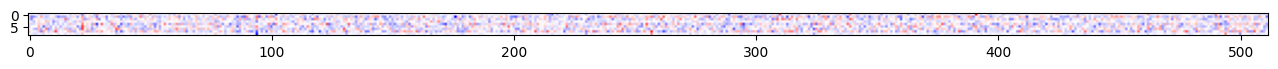

In [358]:
plt.figure(figsize=(16, 1))
plt.imshow(
    embedded_tokens.detach().numpy()[0,:,:512],
    cmap="bwr",
)

In [222]:
enc_output = embedded_tokens
for i, layer in enumerate(model.model.layers, start=1):
    enc_output = layer(enc_output)[0]
    print(f"Layer {i}", enc_output.shape)

Layer 1 torch.Size([1, 9, 4096])
Layer 2 torch.Size([1, 9, 4096])
Layer 3 torch.Size([1, 9, 4096])
Layer 4 torch.Size([1, 9, 4096])
Layer 5 torch.Size([1, 9, 4096])
Layer 6 torch.Size([1, 9, 4096])
Layer 7 torch.Size([1, 9, 4096])
Layer 8 torch.Size([1, 9, 4096])
Layer 9 torch.Size([1, 9, 4096])
Layer 10 torch.Size([1, 9, 4096])
Layer 11 torch.Size([1, 9, 4096])
Layer 12 torch.Size([1, 9, 4096])
Layer 13 torch.Size([1, 9, 4096])
Layer 14 torch.Size([1, 9, 4096])
Layer 15 torch.Size([1, 9, 4096])
Layer 16 torch.Size([1, 9, 4096])
Layer 17 torch.Size([1, 9, 4096])
Layer 18 torch.Size([1, 9, 4096])
Layer 19 torch.Size([1, 9, 4096])
Layer 20 torch.Size([1, 9, 4096])
Layer 21 torch.Size([1, 9, 4096])
Layer 22 torch.Size([1, 9, 4096])
Layer 23 torch.Size([1, 9, 4096])
Layer 24 torch.Size([1, 9, 4096])
Layer 25 torch.Size([1, 9, 4096])
Layer 26 torch.Size([1, 9, 4096])
Layer 27 torch.Size([1, 9, 4096])
Layer 28 torch.Size([1, 9, 4096])
Layer 29 torch.Size([1, 9, 4096])
Layer 30 torch.Size([1,

### Analyze image data

In [230]:
model.model.vision_tower.vision_tower.vision_model.embeddings

CLIPVisionEmbeddings(
  (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
  (position_embedding): Embedding(577, 1024)
)

In [360]:
model.model.vision_tower.vision_tower.vision_model.embeddings.patch_embedding(images).shape

torch.Size([1, 1024, 24, 24])

In [233]:
model.model.vision_tower.vision_tower.vision_model.embeddings(images).shape

torch.Size([1, 577, 1024])

In [243]:
# model.model.vision_tower

In [301]:
emb = model.model.vision_tower(images)

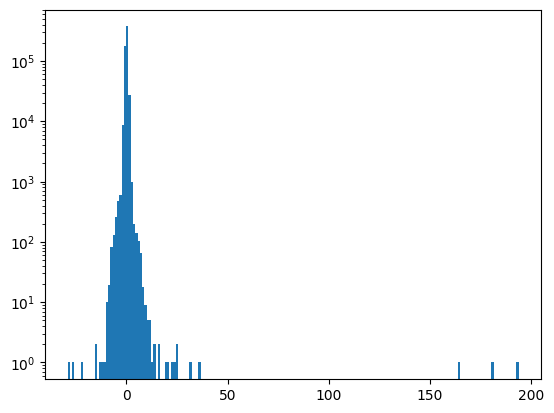

In [303]:
plt.hist(
    emb.flatten(),
    log=True,
    bins=200,
)
plt.show()

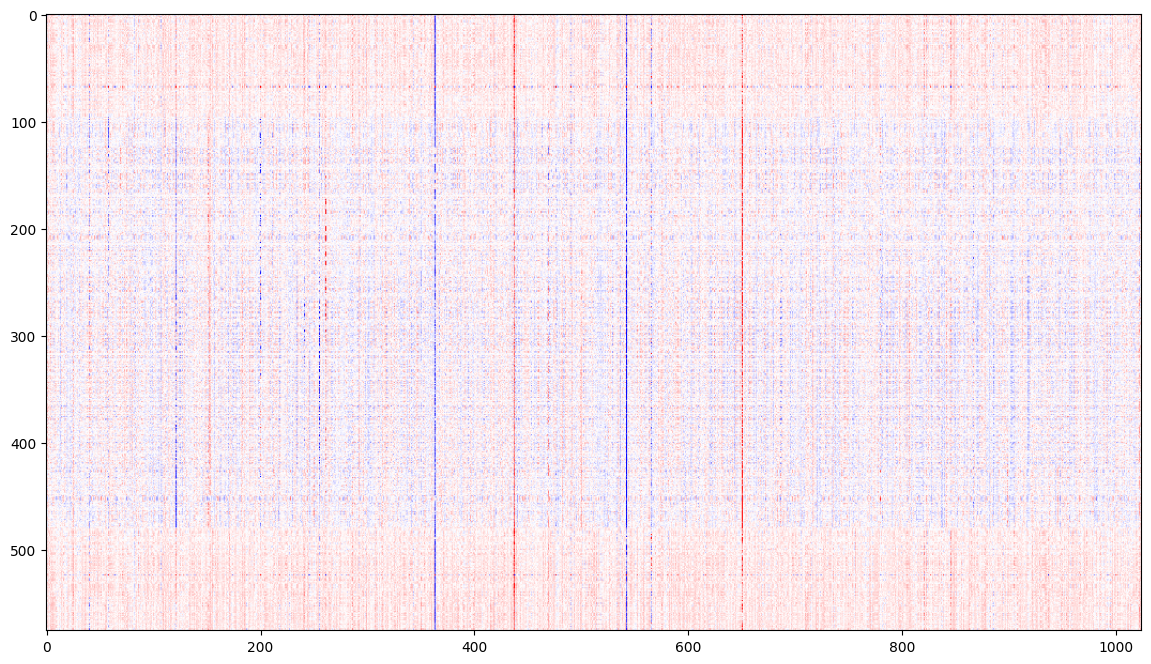

In [311]:
plt.figure(figsize=(16, 8))
plt.imshow(
    emb[0, :, :],
    vmin=-5,
    vmax=5,
    cmap="bwr"
)
plt.show()

In [306]:
mm_emb = model.model.mm_projector(emb)

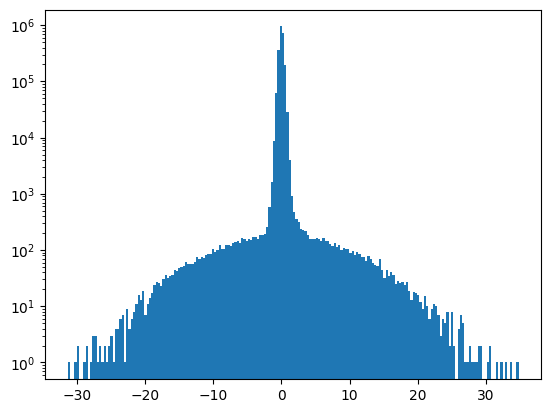

In [275]:
plt.hist(
    mm_emb.detach().numpy().flatten(),
    log=True,
    bins=200,
)
plt.show()

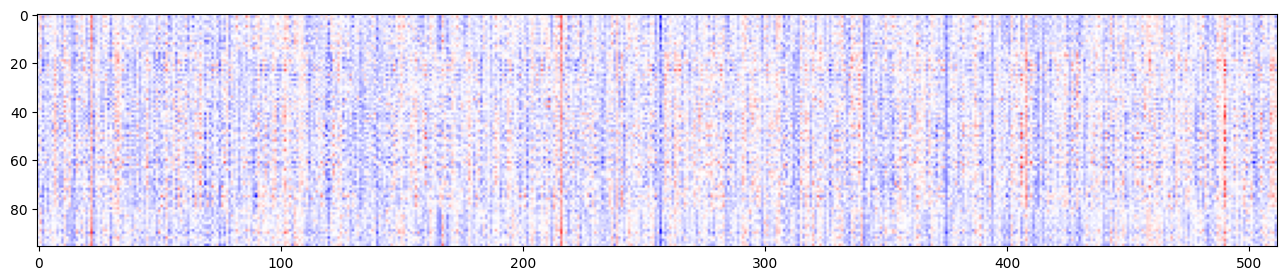

In [312]:
plt.figure(figsize=(16, 8))
plt.imshow(
    mm_emb.detach().numpy()[0, ::6, :512],
    cmap="bwr",
)

### Map image to textual tokens

In [363]:
token_ids_recovered = embedding_to_token_id(mm_emb, model.model.embed_tokens)
print(tokenizer.decode(token_ids_recovered[0]))

iful brown\\никly\\Ographics grayar\\ leastнияüyникlyyyщиnestadersug browny grayщиникaders wishOO\\чOüчщиntчщиło leastagingnestниккальynest leastкаль\\lyardonкваO least grayenthabeч Rouнияч\\ mm grayighigh\\yUelloyнияfrastrygraphics gleichyyOabeтальnt leastния brigATHyщиччy mark pleasedfilmO**ник Dbimb lights light light Head light light lightdyyellowasstain**firewsnest roomnestixel roomnestник introimbFS red Head lightsantry red light intro next month units Head metal赤 Headws** upperタМ littber чоловіimb hotools head head Head Redothy DbtainPUT Head Head capmid redчgraphicsч green roomenth youber you month Head person person person Headothyникservppppanancc darkжде少ч roomnest少 roomunestesimb head person person person people darkness Iserv yellow glass glass glassan east youngerdy dragUT darknestниц dis goldenщи persons person mouth personских black blackserv golden man ein ein mentmp dark roomnestMy bed bed bed nextththurщи manа monthщи twoven bed two eastinsantщищи Institute nelloMydy

In [362]:
for token_id in token_ids_recovered[0][::10]:
    if token_id < 0:
        print(f"Token {token_id:5}: RESERVED_TOKEN")
        continue
    print(f"Token {token_id:5}: '{tokenizer.decode(token_id)}'")

Token  6845: 'iful'
Token  1966: '\\'
Token 17510: 'nest'
Token 29949: 'O'
Token  2837: 'щи'
Token 18735: 'каль'
Token 29981: 'ч'
Token 29891: 'y'
Token 29891: 'y'
Token  2837: 'щи'
Token 24331: 'Db'
Token 29136: 'yellow'
Token  5716: 'room'
Token  2654: 'red'
Token  5652: 'ws'
Token  8789: 'ools'
Token 12252: 'Head'
Token   366: 'you'
Token  3316: 'ник'
Token 29981: 'ч'
Token  2022: 'person'
Token   273: 'an'
Token 22843: 'golden'
Token 22843: 'golden'
Token  6592: 'bed'
Token  2837: 'щи'
Token  8907: 'Institute'
Token  4457: 'sin'
Token   767: 'man'
Token  2654: 'red'
Token  1023: 'two'
Token  2654: 'red'
Token  7933: 'green'
Token  1132: 'oup'
Token  1020: 'tra'
Token 12928: 'скую'
Token 17510: 'nest'
Token 29136: 'yellow'
Token   615: 'ft'
Token  1591: 'table'
Token 18046: 'bott'
Token  3712: 'mon'
Token  2968: 'пу'
Token  1408: 'ething'
Token  7515: 'irth'
Token 25972: 'basket'
Token 30369: 'タ'
Token  4518: 'dy'
Token 17510: 'nest'
Token 19896: 'argent'
Token 29981: 'ч'
Token  196